In [2]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics 
import tqdm
import os
import sys
import scanpy as sc
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu
# from dredFISH.Analysis import powerplots

importlib.reload(basicu)

sns.set_context('talk')

In [3]:
fig_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/figures/'

# Load data

In [4]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [5]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v2_annot.h5ad')
adata

CPU times: user 568 ms, sys: 422 ms, total: 990 ms
Wall time: 9.86 s


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

# PCA matrix

In [6]:
# PCA
pca = PCA(n_components=None).fit(adata.X)
pca_v = pca.explained_variance_ratio_
pcX = pca.transform(adata.X)

loading1 = pca.components_[0,:]
loading2 = pca.components_[1,:]
geneidxrank1 = np.argsort(np.abs(loading1))[::-1]
geneidxrank2 = np.argsort(np.abs(loading2))[::-1]

for i in np.arange(pcX.shape[1]):
    adata.obs[f'PC_{i+1}'] = pcX[:,i]

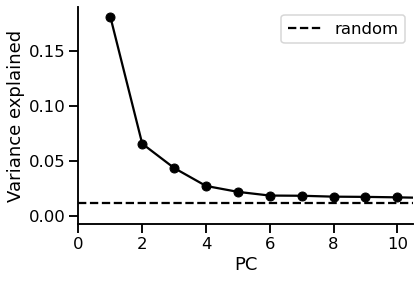

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(pca_v))+1, pca_v, '-ok')
ax.axhline(1/len(pca_v), label='random', linestyle='--', color='k')
ax.set_xlabel('PC')
ax.set_ylabel('Variance explained')
ax.set_xlim([0,10.5])
ax.legend()
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_varexp.pdf'))
plt.show()



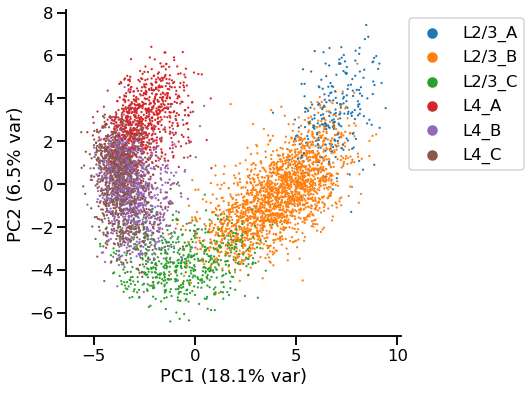

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=adata.obs, 
                x='PC_1',
                y='PC_2',
                hue='cluster',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

# get diffusion map

In [9]:
sc.tl.diffmap(adata)
adata.obsm['X_diffmap'].shape

(5837, 15)

In [10]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cluster']=='L2/3_A')[0]

In [11]:
sc.tl.dpt(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

# check pseudotime (and diff map)

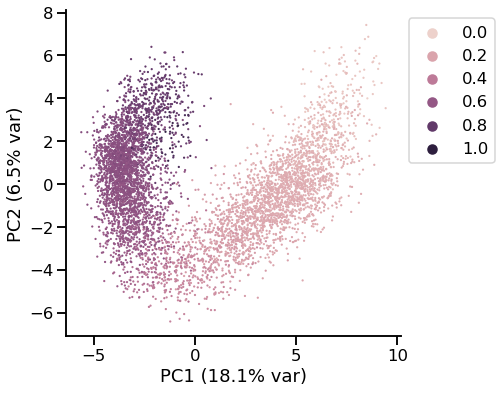

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=adata.obs, 
                x='PC_1',
                y='PC_2',
                hue='dpt_pseudotime',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

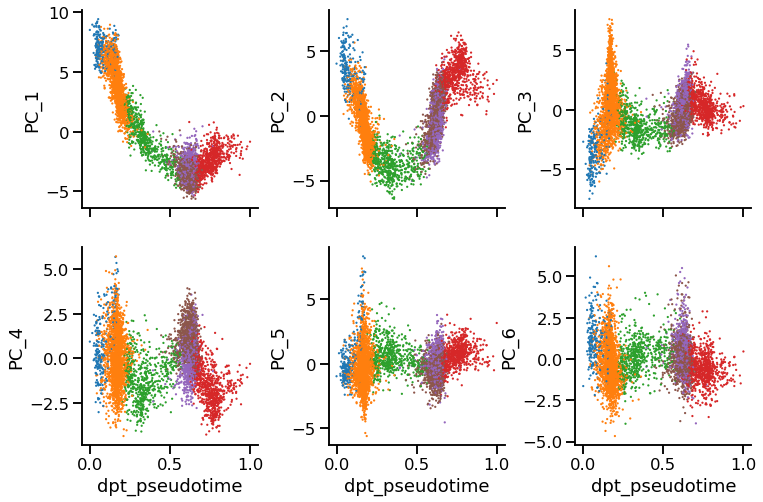

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=adata.obs, 
                    x='dpt_pseudotime',
                    y=f'PC_{i+1}',
                    # y='PC_2',
                    hue='cluster',
                    hue_order=np.sort(adata.obs['cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
# ax.set_xlabel(f'PC1 ({pca_v[i]*100:.1f}% var)')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
# fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
plt.show()

# check genes vs pseudotime

In [15]:
adata.X.shape

(5837, 86)

100%|██████████| 86/86 [00:03<00:00, 23.64it/s]


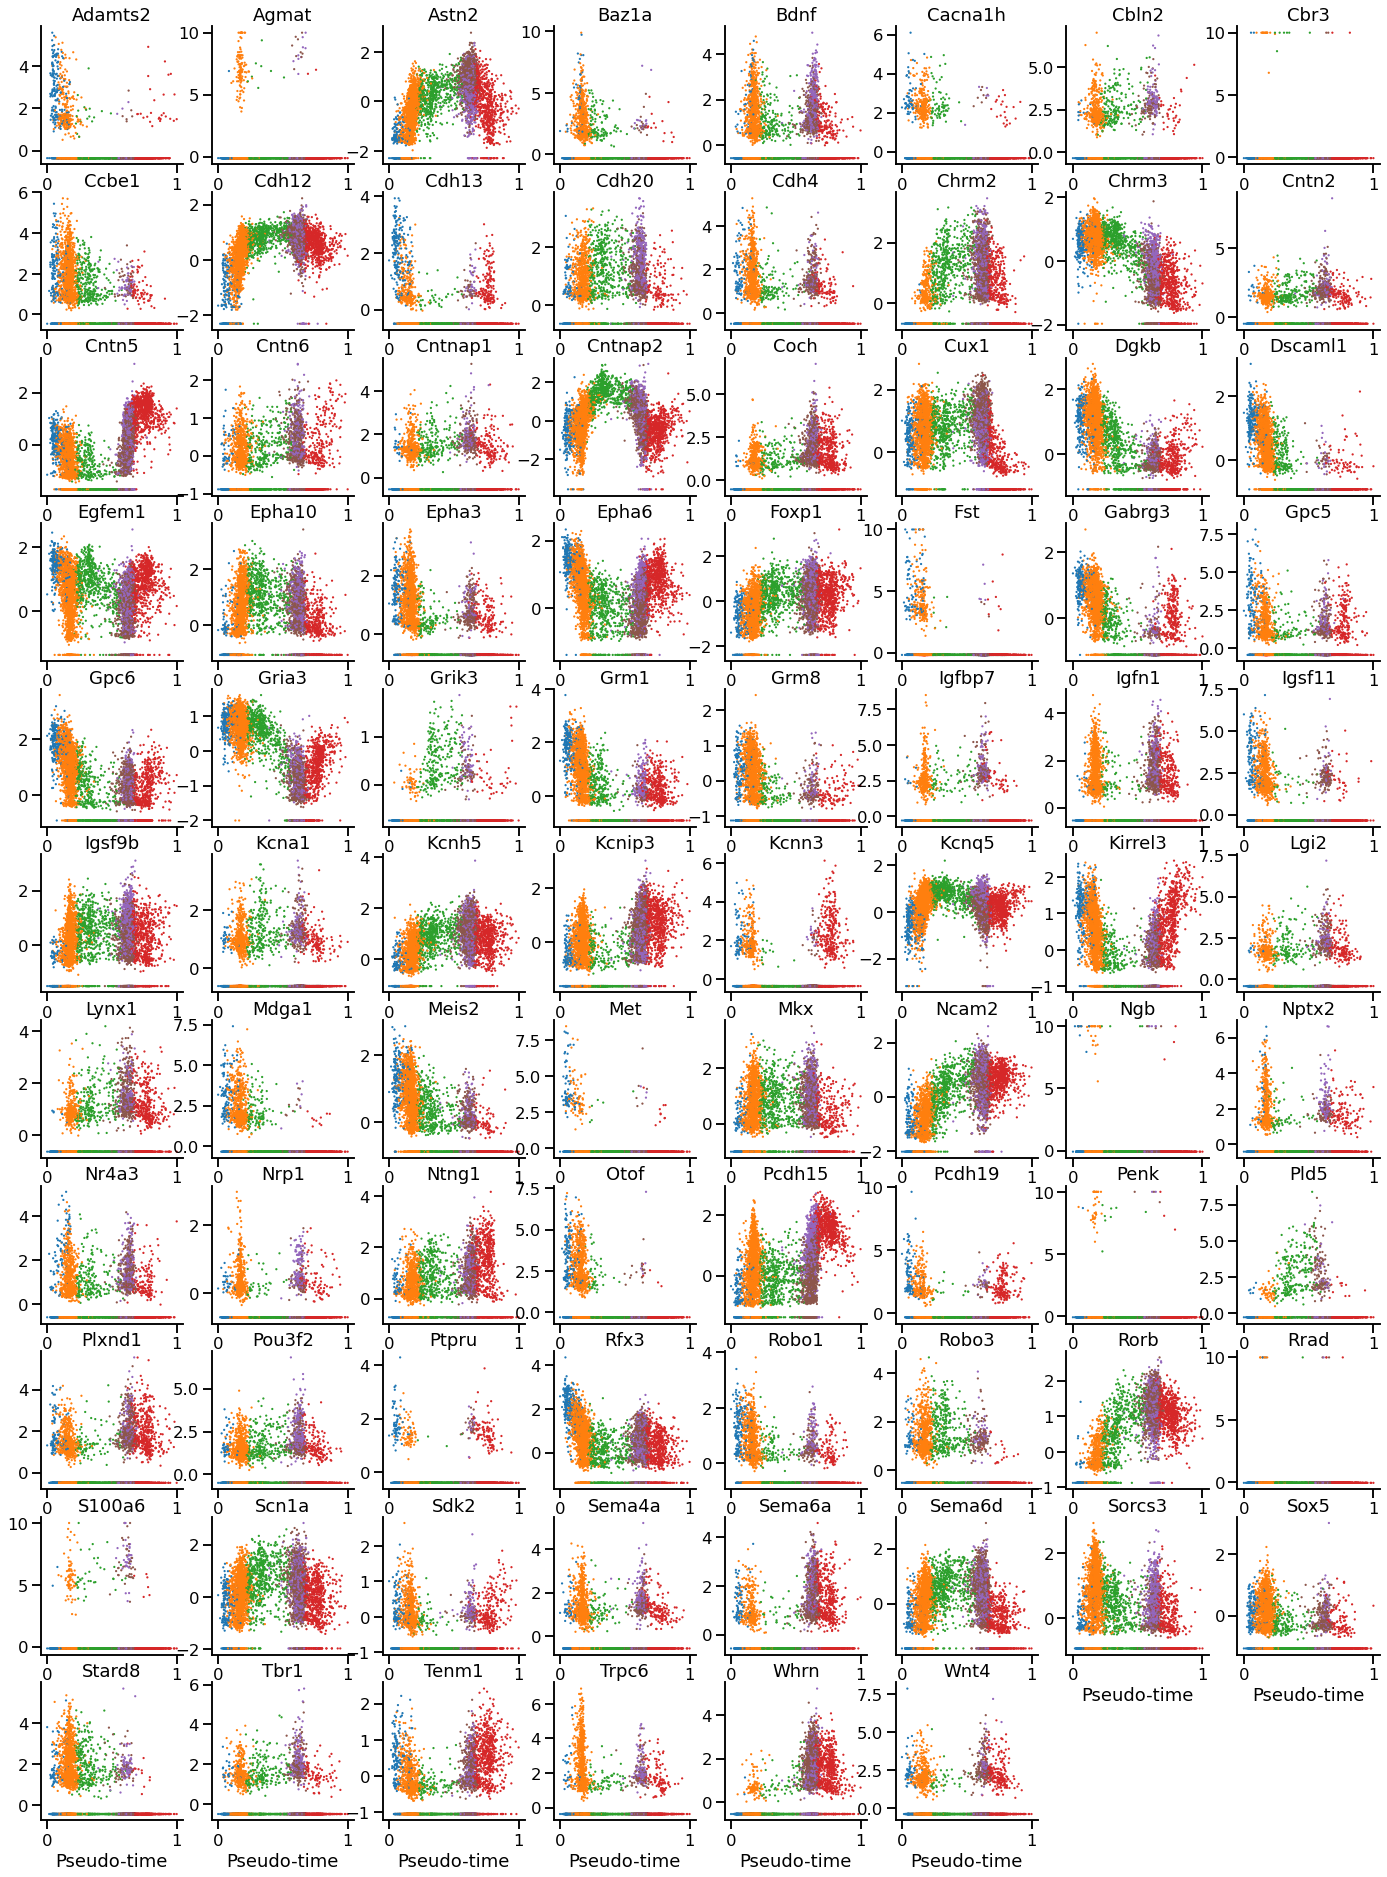

In [16]:
t = adata.obs['dpt_pseudotime'].values
genes = adata.var.index.values

_df = pd.DataFrame(adata.X)
_df['t'] = t
_df['cluster'] = adata.obs['cluster'].values

hue_order = np.sort(adata.obs['cluster'].unique())

fig, axs = plt.subplots(11,8, figsize=(8*3,11*3))
for i in tqdm.tqdm(np.arange(86)):
    ax = axs.flat[i]
    
    sns.scatterplot(data=_df, 
                    x='t',
                    y=i,
                    # y='PC_2',
                    hue='cluster',
                    hue_order=hue_order,
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    
    ax.set_title(genes[i])
    ax.set_xlabel('Pseudo-time')
    ax.set_ylabel('')
    
    sns.despine(ax=ax)
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
plt.show()

In [20]:
from dredFISH.Analysis import basicu

In [24]:
def plot_ij(i, j):
    """
    """
    fig, ax = plt.subplots(1,1, figsize=(1*3,1*3))
    sns.scatterplot(data=_df, 
                    x=i,
                    y=j,
                    hue='cluster',
                    hue_order=hue_order,
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )

    ax.set_xlabel(genes[i])
    ax.set_ylabel(genes[j])

    sns.despine(ax=ax)
    plt.show()

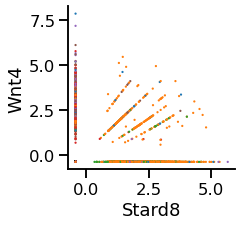

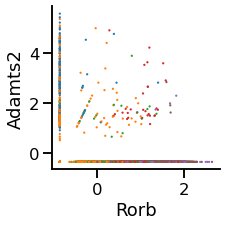

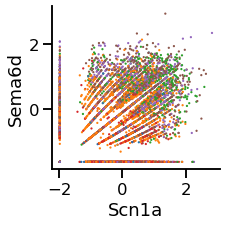

In [27]:
i = basicu.get_index_from_array(genes, ['Stard8'])[0]
j = basicu.get_index_from_array(genes, ['Wnt4'])[0]
plot_ij(i,j)

i = basicu.get_index_from_array(genes, ['Rorb'])[0]
j = basicu.get_index_from_array(genes, ['Adamts2'])[0]
plot_ij(i,j)

i = basicu.get_index_from_array(genes, ['Scn1a'])[0]
j = basicu.get_index_from_array(genes, ['Sema6d'])[0]
plot_ij(i,j)

